In [1]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_filtered_est = pd.read_csv('./csvs/df_filtered_est.csv')
df_filtered_tst = pd.read_csv('./csvs/df_filtered_tst.csv')
df_filtered_shbg = pd.read_csv('./csvs/df_filtered_shbg.csv')

In [3]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer


# ---------- Your custom domain rules ----------
def preprocess_domain_rules(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    is_male = df["RIAGENDR"] == 1
    is_female = df["RIAGENDR"] == 2
    age = df["RIDAGEMN"]

    # Adjust pregnancy code
    df.loc[is_male, "RIDEXPRG"] = 300
    df.loc[is_female & (age < 20), "RIDEXPRG"] = 202
    df.loc[is_female & (age > 44), "RIDEXPRG"] = 203

    df = mark_male_nans(df, male_code=300)
    return df


def mark_male_nans(df: pd.DataFrame, rhq_prefixes=('RHQ', 'RHD'), male_code=300) -> pd.DataFrame:
    df = df.copy()
    rhq_cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in rhq_prefixes)]
    male_mask = df['RIAGENDR'] == 1
    for col in rhq_cols:
        df.loc[male_mask & df[col].isna(), col] = male_code
    return df


# ---------- Custom Wrapper for sklearn ----------
class PandasFunctionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, func):
        self.func = func

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Ensure DataFrame input
        X = pd.DataFrame(X, columns=self.feature_names_in_)
        return self.func(X)


# ---------- Example setup ----------
def build_pipeline(continuous_cols, categorical_cols):
    # Pre-step: apply domain rules
    domain_rules_step = ("domain_rules", PandasFunctionTransformer(preprocess_domain_rules))

    # Continuous pipeline
    continuous_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    # Categorical pipeline
    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent"))
    ])

    # Combine
    preprocessor = ColumnTransformer(transformers=[
        ("cont", continuous_pipeline, continuous_cols),
        ("cat", categorical_pipeline, categorical_cols)
    ])

    # Full pipeline
    full_pipeline = Pipeline(steps=[
        domain_rules_step,
        ("preprocessor", preprocessor)
    ])

    return full_pipeline


In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor


# ------------------ Domain rules ------------------ #
def preprocess_domain_rules(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    is_male = df["RIAGENDR"] == 1
    is_female = df["RIAGENDR"] == 2
    age = df["RIDAGEMN"]

    # Adjust pregnancy code
    df.loc[is_male, "RIDEXPRG"] = 300
    df.loc[is_female & (age < 20), "RIDEXPRG"] = 202
    df.loc[is_female & (age > 44), "RIDEXPRG"] = 203

    # Apply domain rule: if age < 20 yrs & RHQ131 is NaN -> set to 3
    df.loc[(df["RIDAGEMN"] < 12 * 20) & (df["RHQ131"].isna()), "RHQ131"] = 3

    df = mark_male_nans(df, male_code=-1)
    return df


def mark_male_nans(df: pd.DataFrame, rhq_prefixes=('RHQ', 'RHD'), male_code=300) -> pd.DataFrame:
    df = df.copy()
    rhq_cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in rhq_prefixes)]
    male_mask = df['RIAGENDR'] == 1
    for col in rhq_cols:
        df.loc[male_mask & df[col].isna(), col] = male_code
    return df


# ------------------ Build pipeline ------------------ #
def build_pipeline(continuous_cols, categorical_cols):
    # Continuous pipeline
    continuous_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    # Categorical pipeline
    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent"))
    ])

    # Combine
    preprocessor = ColumnTransformer(transformers=[
        ("cont", continuous_pipeline, continuous_cols),
        ("cat", categorical_pipeline, categorical_cols)
    ])

    # Full pipeline (with model at the end)
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", XGBRegressor(random_state=42, n_jobs=-1))
    ])

    return pipeline

In [5]:
# ------------------ Training & Evaluation ------------------ #
def train_and_evaluate(df, continuous_cols, target_col):
    # Apply domain rules ONCE before split
    df = preprocess_domain_rules(df)

    # Split features / target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Identify categorical columns
    categorical_cols = [col for col in X.columns if col not in continuous_cols]

    # Build pipeline
    pipeline = build_pipeline(continuous_cols, categorical_cols)

    # Define grid
    param_grid = {
        "model__n_estimators": [20, 100, 500, 1000],
        "model__max_depth": [3, 5, 7, 12],
        "model__learning_rate": [0.05, 0.1, 0.001, 0.01]
    }

    # Grid search
    gs = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        # verbose=2
    )

    gs.fit(X_train, y_train)

    # Best model
    best_model = gs.best_estimator_

    # Predictions
    y_pred = best_model.predict(X_test)

    # Error metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("Best Params:", gs.best_params_)
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R2:", r2)

    return best_model, gs

In [6]:
# ------------------ Example usage ------------------ #
continuous_cols = ['LBDBPBSI', 'LBDBCDSI', 'LBDTHGSI', 'LBDBSESI', 'LBDBMNSI']
target_col = "LBXEST"
best_model, gs = train_and_evaluate(df_filtered_est, continuous_cols, target_col)

KeyboardInterrupt: 

In [16]:
# ------------------ Example usage ------------------ #
continuous_cols = ['LBDBPBSI', 'LBDBCDSI', 'LBDTHGSI', 'LBDBSESI', 'LBDBMNSI']
target_col = "LBXTST"
best_model, gs = train_and_evaluate(df_filtered_tst, continuous_cols, target_col)

Best Params: {'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__n_estimators': 500}
MAE: 55.694227448816264
MSE: 11445.723714808375
RMSE: 106.98468916068492
R2: 0.7842922715926991


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def feature_sensitivity_single(model, X_row, feature, 
                               num_points=1000, 
                               scale="auto", 
                               do_plot=True):
    """
    Sensitivity analysis for a single record.
    
    Parameters
    ----------
    model : trained pipeline (e.g., best_model)
    X_row : pd.Series
        One row of features (before preprocessing).
    feature : str
        Feature to vary.
    num_points : int, optional
        Number of grid points.
    scale : "auto" | tuple(float, float)
        Range of variation:
        - "auto": use [X_row[feature]*0.5, X_row[feature]*1.5]
        - tuple(min, max): custom range
    do_plot : bool
        Whether to plot predictions.
    
    Returns
    -------
    pd.DataFrame with varied feature values and predictions.
    """
    if feature not in X_row.index:
        raise ValueError(f"Feature '{feature}' not in record")

    base_value = X_row[feature]

    # Choose range
    if scale == "auto":
        fmin, fmax = base_value * 0.5, base_value * 2
    else:
        fmin, fmax = scale

    feature_values = np.linspace(fmin, fmax, num_points)

    # Duplicate the record and vary only this feature
    varied_rows = pd.DataFrame([X_row.values] * num_points, columns=X_row.index)
    varied_rows[feature] = feature_values

    # Predict
    preds = model.predict(varied_rows)

    results = pd.DataFrame({
        feature: feature_values,
        "prediction": preds
    })

    # Plot
    if do_plot:
        plt.figure(figsize=(6, 4))
        plt.plot(results[feature], results["prediction"], marker="o")
        plt.axvline(base_value, color="red", linestyle="--", label="Original value")
        plt.xlabel(feature)
        plt.ylabel("Prediction")
        plt.title(f"Sensitivity of prediction to {feature}")
        plt.legend()
        plt.grid(True)
        plt.show()

    return results


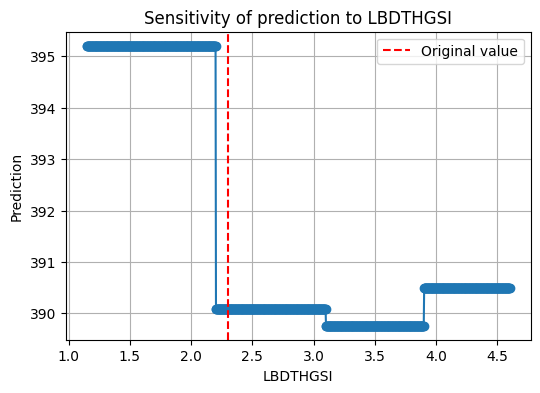

   LBDTHGSI  prediction
0  1.150000  395.207092
1  1.153453  395.207092
2  1.156907  395.207092
3  1.160360  395.207092
4  1.163814  395.207092


In [32]:
# Take one record (e.g., first test row)
X_sample = df_filtered_tst.drop(columns=[target_col]).iloc[0]

results = feature_sensitivity_single(
    best_model, 
    X_sample, 
    feature="LBDTHGSI", 
    num_points=1000, 
    scale="auto", 
    do_plot=True
)

print(results.head())


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def feature_sensitivity_single(model, X_row, feature, 
                               num_points=1000, 
                               scale="auto", 
                               do_plot=True):
    """
    Sensitivity analysis for a single record with smoothed curve.
    """
    if feature not in X_row.index:
        raise ValueError(f"Feature '{feature}' not in record")

    base_value = X_row[feature]

    # Choose range
    if scale == "auto":
        fmin, fmax = base_value * 0.1, base_value * 10
    else:
        fmin, fmax = scale

    feature_values = np.linspace(fmin, fmax, num_points)

    # Duplicate the record and vary only this feature
    varied_rows = pd.DataFrame([X_row.values] * num_points, columns=X_row.index)
    varied_rows[feature] = feature_values

    # Predict
    preds = model.predict(varied_rows)

    results = pd.DataFrame({
        feature: feature_values,
        "prediction": preds
    })

    # Plot
    if do_plot:
        plt.figure(figsize=(6, 4))

        # Generate smooth curve (interpolation)
        x_smooth = np.linspace(feature_values.min(), feature_values.max(), 500)
        try:
            spline = make_interp_spline(feature_values, preds, k=3)  # cubic spline
            y_smooth = spline(x_smooth)
            plt.plot(x_smooth, y_smooth, label="Smoothed prediction")
        except Exception:
            # fallback: normal plot if spline fails
            plt.plot(feature_values, preds, marker="o", label="Prediction")

        plt.axvline(base_value, color="red", linestyle="--", label="Original value")
        plt.xlabel(feature)
        plt.ylabel("Prediction")
        plt.title(f"Sensitivity of prediction to {feature}")
        plt.legend()
        plt.grid(True)
        plt.show()

    return results


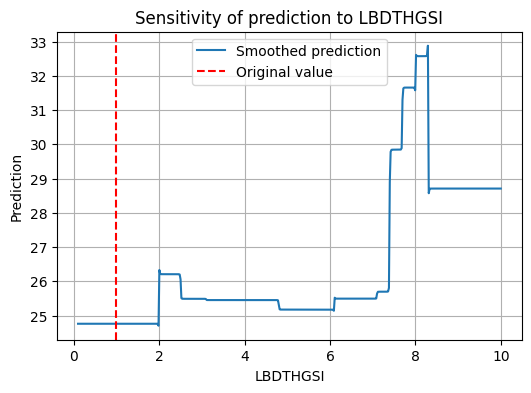

In [56]:
# Pick one patient/sample
X_sample = df_filtered_tst.drop(columns=[target_col]).iloc[100]

results = feature_sensitivity_single(
    best_model, 
    X_sample, 
    feature="LBDTHGSI", 
    num_points=1000, 
    do_plot=True
)


In [47]:
results

,LBDTHGSI,prediction
0,0.069,449.863220
1,0.138,449.863220
2,0.207,449.863220
3,0.276,449.863220
4,0.345,449.863220
...,...,...
995,68.724,536.516052
996,68.793,536.516052
997,68.862,536.516052
998,68.931,536.516052


In [9]:
# ------------------ Example usage ------------------ #
continuous_cols = ['LBDBPBSI', 'LBDBCDSI', 'LBDTHGSI', 'LBDBSESI', 'LBDBMNSI']
target_col = "LBXSHBG"
best_model, gs = train_and_evaluate(df_filtered_shbg, continuous_cols, target_col)

Best Params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 1000}
MAE: 23.943457504155983
MSE: 1148.8896034938493
RMSE: 33.89527405839713
R2: 0.366298622566514


In [ ]:
df_filtered_est.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4050 entries, 0 to 4049
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LBXEST         4050 non-null   float64
 1   LBDBSESI       4047 non-null   float64
 2   LBDTHGSI       4048 non-null   float64
 3   LBDBCDSI       4048 non-null   float64
 4   LBDBPBSI       4048 non-null   float64
 5   RIDAGEMN       4050 non-null   float64
 6   RHQ160         3190 non-null   float64
 7   LBDBMNSI       4047 non-null   float64
 8   RIAGENDR       4050 non-null   int64  
 9   RIDEXPRG       4050 non-null   float64
 10  BMXBMI         4018 non-null   float64
 11  RHQ031         3436 non-null   float64
 12  is_menopausal  4050 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 411.5 KB


In [15]:
import joblib

# ------------------ Training & Evaluation ------------------ #
def train_and_evaluate(df, continuous_cols, target_col, model_path="best_xgb_model.joblib"):
    # Apply domain rules ONCE before split
    df = preprocess_domain_rules(df)

    # Split features / target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Identify categorical columns
    categorical_cols = [col for col in X.columns if col not in continuous_cols]

    # Build pipeline
    pipeline = build_pipeline(continuous_cols, categorical_cols.drop(["RIDAGEMN"]))

    # Define grid
    param_grid = {
        "model__n_estimators": [20, 100, 500, 1000],
        "model__max_depth": [3, 5, 7, 12],
        "model__learning_rate": [0.05, 0.1, 0.001, 0.01]
    }

    # Grid search
    gs = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )

    gs.fit(X_train, y_train)

    # Best model
    best_model = gs.best_estimator_

    # Predictions
    y_pred = best_model.predict(X_test)

    # Error metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("Best Params:", gs.best_params_)
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R2:", r2)

    # Save best model
    joblib.dump(best_model, model_path)
    print(f"Best model saved at: {model_path}")

    # Get feature order (after preprocessing)
    feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
    print("Feature order:", feature_names)

    return best_model, gs, feature_names

In [ ]:
continuous_cols = ['LBDBPBSI', 'LBDBCDSI', 'LBDTHGSI', 'LBDBSESI', 'LBDBMNSI','BMXBMI'] 
target_col = "LBXTST"

best_model, gs, feature_names = train_and_evaluate(
    df_filtered_tst,
    continuous_cols,
    target_col,
    model_path="xgb_model_tst_01.joblib"
)

TypeError: train_and_evaluate() got an unexpected keyword argument 'model_path'

In [ ]:
feature_names

array(['cont__LBDBPBSI', 'cont__LBDBCDSI', 'cont__LBDTHGSI',
       'cont__LBDBSESI', 'cont__LBDBMNSI', 'cont__BMXBMI',
       'cat__RIDAGEMN', 'cat__RHQ131', 'cat__RIAGENDR', 'cat__RIDEXPRG'],
      dtype=object)

In [ ]:
df_filtered_tst.columns

Index(['LBXTST', 'LBDBSESI', 'LBDTHGSI', 'LBDBCDSI', 'LBDBPBSI', 'RIDAGEMN',
       'LBDBMNSI', 'RHQ131', 'RIAGENDR', 'RIDEXPRG', 'BMXBMI'],
      dtype='object')

In [9]:
continuous_cols = ['LBDBPBSI', 'LBDBCDSI', 'LBDTHGSI', 'LBDBSESI', 'LBDBMNSI','BMXBMI']
target_col = "LBXSHBG"

best_model, gs, feature_names = train_and_evaluate(
    df_filtered_shbg,
    continuous_cols,
    target_col,
    model_path="xgb_model_shbg_01.joblib"
)

Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
MAE: 23.989008325814595
MSE: 1155.8240301068713
RMSE: 33.997412108966046
R2: 0.36247375054833253
Best model saved at: xgb_model_shbg_01.joblib
Feature order: ['cont__LBDBPBSI' 'cont__LBDBCDSI' 'cont__LBDTHGSI' 'cont__LBDBSESI'
 'cont__LBDBMNSI' 'cont__BMXBMI' 'cat__RIDAGEMN' 'cat__RHQ131'
 'cat__RIAGENDR' 'cat__RIDEXPRG']


In [ ]:
continuous_cols = ['LBDBPBSI', 'LBDBCDSI', 'LBDTHGSI', 'LBDBSESI', 'LBDBMNSI','BMXBMI']
target_col = "LBXEST"

best_model, gs, feature_names = train_and_evaluate(
    df_filtered_est,
    continuous_cols,
    target_col,
    model_path="xgb_model_est_01.joblib"
)

Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 20}
MAE: 24.859746068926214
MSE: 5595.944585574815
RMSE: 74.8060464506367
R2: 0.14841207558771463
Best model saved at: xgb_model_est_01.joblib
Feature order: ['cont__LBDBPBSI' 'cont__LBDBCDSI' 'cont__LBDTHGSI' 'cont__LBDBSESI'
 'cont__LBDBMNSI' 'cont__BMXBMI' 'cat__RIDAGEMN' 'cat__RHQ131'
 'cat__RIAGENDR' 'cat__RIDEXPRG' 'cat__RHQ031']


In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor

def build_pipeline(continuous_cols, categorical_cols, passthrough_cols=None):
    if passthrough_cols is None:
        passthrough_cols = []

    # Continuous pipeline
    continuous_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    # Categorical pipeline
    categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent"))
    ])

    # Combine
    preprocessor = ColumnTransformer(transformers=[
        ("cont", continuous_pipeline, continuous_cols),
        ("cat", categorical_pipeline, categorical_cols),
        ("pass", "passthrough", passthrough_cols)
    ])

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", XGBRegressor(random_state=42, n_jobs=-1))
    ])

    return pipeline


In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class DomainRuleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # no parameters needed

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Apply your domain preprocessing
        X = preprocess_domain_rules(X)
        return X


In [22]:
def train_and_evaluate(df, continuous_cols, target_col, passthrough_cols=None, model_path="best_xgb_model.joblib"):
    if passthrough_cols is None:
        passthrough_cols = []

    # Split features / target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Identify categorical columns
    categorical_cols = [col for col in X.columns if col not in continuous_cols + passthrough_cols]

    # Build main preprocessing pipeline
    preprocessing_pipeline = build_pipeline(continuous_cols, categorical_cols, passthrough_cols)

    # Combine domain rules + preprocessing + model
    full_pipeline = Pipeline(steps=[
        # ("domain_rules", DomainRuleTransformer()),
        ("preprocessor_and_model", preprocessing_pipeline)
    ])

    # Define grid
    param_grid = {
        "preprocessor_and_model__model__n_estimators": [100, 500],
        "preprocessor_and_model__model__max_depth": [3, 5, 7],
        "preprocessor_and_model__model__learning_rate": [0.05, 0.1, 0.01]
    }

    gs = GridSearchCV(
        full_pipeline,
        param_grid,
        cv=3,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )

    gs.fit(X_train, y_train)

    # Best model
    best_model = gs.best_estimator_

    # Predictions
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("Best Params:", gs.best_params_)
    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R2:", r2)

    joblib.dump(best_model, model_path)
    print(f"✅ Best model saved at: {model_path}")

    # Access feature names (from the preprocessor inside)
    feature_names = best_model.named_steps["preprocessor_and_model"].named_steps["preprocessor"].get_feature_names_out()
    print("Feature order:", feature_names)

    return best_model, gs, feature_names


In [27]:
df_filtered_est.columns

Index(['LBXEST', 'LBDBSESI', 'LBDTHGSI', 'LBDBCDSI', 'LBDBPBSI', 'RIDAGEMN',
       'LBDBMNSI', 'RHQ131', 'RIAGENDR', 'RIDEXPRG', 'BMXBMI', 'RHQ031',
       'is_menopausal'],
      dtype='object')

In [28]:
df_filtered_est["RHQ031"].value_counts()

RHQ031
-1.0      2024
 1.0       769
 2.0       630
 500.0      13
Name: count, dtype: int64

In [24]:
continuous_cols = ['LBDBPBSI', 'LBDBCDSI', 'LBDTHGSI', 'LBDBSESI', 'LBDBMNSI','BMXBMI']
passthrough_cols = ['RIDAGEMN','RHQ131']
target_col = "LBXSHBG"

best_model, gs, feature_names = train_and_evaluate(
    df_filtered_shbg,
    continuous_cols,
    target_col,
    passthrough_cols=passthrough_cols,
    model_path="xgb_model_shbg_03.joblib"
)

Best Params: {'preprocessor_and_model__model__learning_rate': 0.05, 'preprocessor_and_model__model__max_depth': 5, 'preprocessor_and_model__model__n_estimators': 100}
MAE: 22.7848556635034
MSE: 1006.2478149602804
RMSE: 31.72140941005428
R2: 0.4449765891861176
✅ Best model saved at: xgb_model_shbg_03.joblib
Feature order: ['cont__LBDBPBSI' 'cont__LBDBCDSI' 'cont__LBDTHGSI' 'cont__LBDBSESI'
 'cont__LBDBMNSI' 'cont__BMXBMI' 'cat__RIAGENDR' 'cat__RIDEXPRG'
 'pass__RIDAGEMN' 'pass__RHQ131']


In [23]:
continuous_cols = ['LBDBPBSI', 'LBDBCDSI', 'LBDTHGSI', 'LBDBSESI', 'LBDBMNSI','BMXBMI']
passthrough_cols = ['RIDAGEMN','RHQ131']
target_col = "LBXEST"

best_model, gs, feature_names = train_and_evaluate(
    df_filtered_est,
    continuous_cols,
    target_col,
    passthrough_cols=passthrough_cols,
    model_path="xgb_model_est_02.joblib"
)

Best Params: {'preprocessor_and_model__model__learning_rate': 0.05, 'preprocessor_and_model__model__max_depth': 5, 'preprocessor_and_model__model__n_estimators': 100}
MAE: 22.207169826424344
MSE: 3098.042607791915
RMSE: 55.6600629517423
R2: 0.5285414939756163
✅ Best model saved at: xgb_model_est_02.joblib
Feature order: ['cont__LBDBPBSI' 'cont__LBDBCDSI' 'cont__LBDTHGSI' 'cont__LBDBSESI'
 'cont__LBDBMNSI' 'cont__BMXBMI' 'cat__RIAGENDR' 'cat__RIDEXPRG'
 'cat__RHQ031' 'cat__is_menopausal' 'pass__RIDAGEMN' 'pass__RHQ131']


In [26]:
continuous_cols = ['LBDBPBSI', 'LBDBCDSI', 'LBDTHGSI', 'LBDBSESI', 'LBDBMNSI','BMXBMI']
passthrough_cols = ['RIDAGEMN']
target_col = "LBXTST"

best_model, gs, feature_names = train_and_evaluate(
    df_filtered_tst,
    continuous_cols,
    target_col,
    passthrough_cols=passthrough_cols,
    model_path="xgb_model_tst_03.joblib"
)

Best Params: {'preprocessor_and_model__model__learning_rate': 0.01, 'preprocessor_and_model__model__max_depth': 5, 'preprocessor_and_model__model__n_estimators': 500}
MAE: 55.39835594847178
MSE: 11406.054494701657
RMSE: 106.79913152597102
R2: 0.7850398833270134
✅ Best model saved at: xgb_model_tst_03.joblib
Feature order: ['cont__LBDBPBSI' 'cont__LBDBCDSI' 'cont__LBDTHGSI' 'cont__LBDBSESI'
 'cont__LBDBMNSI' 'cont__BMXBMI' 'cat__RHQ131' 'cat__RIAGENDR'
 'cat__RIDEXPRG' 'pass__RIDAGEMN']


In [29]:
continuous_cols = ['LBDBPBSI', 'LBDBCDSI', 'LBDTHGSI', 'LBDBSESI', 'LBDBMNSI','BMXBMI']
passthrough_cols = ['RIDAGEMN','RHQ131','RHQ031']
target_col = "LBXEST"

best_model, gs, feature_names = train_and_evaluate(
    df_filtered_est,
    continuous_cols,
    target_col,
    passthrough_cols=passthrough_cols,
    model_path="xgb_model_est_03.joblib"
)

Best Params: {'preprocessor_and_model__model__learning_rate': 0.05, 'preprocessor_and_model__model__max_depth': 5, 'preprocessor_and_model__model__n_estimators': 100}
MAE: 22.070919276702625
MSE: 3063.656694675365
RMSE: 55.35030889412782
R2: 0.5337743242747992
✅ Best model saved at: xgb_model_est_03.joblib
Feature order: ['cont__LBDBPBSI' 'cont__LBDBCDSI' 'cont__LBDTHGSI' 'cont__LBDBSESI'
 'cont__LBDBMNSI' 'cont__BMXBMI' 'cat__RIAGENDR' 'cat__RIDEXPRG'
 'cat__is_menopausal' 'pass__RIDAGEMN' 'pass__RHQ131' 'pass__RHQ031']
